<center><h1> bsolar demonstration </h1></center>

## In this file, we carefully show the output of the key steps in "bsolar_parallel.py" (the parallel version of bsolar)

---

## Check the following before running the code

### (a) Read "README.pdf" in this folder first, which introduces the package

### (b) Before replication, delete all .p files in the "./numerical_result" folder. The .p files record the numerical results of the our computation.

### (c) To avoid confusion, reset your kernel before you running the notebook (to clear memory): 
* <font size="4.5"> In Jupyter Notebook/Lab : go to Menu "Kernel" $\rightarrow$ "Restart Kernel and clear all outputs". </font> 

### (d) To evaluate the code for simulation replication in Jupyter Notebook/Lab,
* <font size="4.5"> click : Menu "Kernel" $\rightarrow$ "Restart Kernel and Run All Cells" </font>
* <font size="4.5"> or, select a cell of code, press "shift" and "enter". Run all cells to avoid errors </font>

### (e) Check "joblib", "scikit-learn", "numpy", "matplotlib" and "tqdm" are installed. If not,
* <font size="4.5"> we highly recommend installing Anaconda3 version 2020-11 directly to avoid package management (all packages mentioned above are installed by default).</font>

---

## Preparation 1: we import all the packages

In [1]:
%reset -f

import numpy             as np
import matplotlib.pyplot as plt
import time
import warnings

from matplotlib.ticker    import MaxNLocator
from joblib               import Parallel, delayed
from sklearn.linear_model import LinearRegression
from solar                import solar
from sklearn.exceptions   import ConvergenceWarning

# For recent version of Scikit-learn: since the class 'Lars' may rely on the Cholesky decomposition and hence may have potential convergence warning in high dimensional data (p is much larger than n), we input the following commmand to skip the convergence warning.
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")

## make sure we use the Intel MKL C++/Fortran compiler for maximum performance.

In [2]:
import mkl

mkl.get_version_string()

'Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904 for Intel(R) 64 architecture applications'

In [3]:
print('This was obtained using the following Numpy configuration:')

np.show_config()

This was obtained using the following Numpy configuration:
blas_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/ning/anaconda3/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/ning/anaconda3/include']
blas_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/ning/anaconda3/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/ning/anaconda3/include']
lapack_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/ning/anaconda3/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/ning/anaconda3/include']
lapack_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/Users/ning/anaconda3/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/Users/ning/anaconda3/include']
Supported SIMD extensions in this NumPy install:
    


## Preparation 2 : we define the data generator for simulations (which is copied from "simulator.py")

In [4]:
class simul:

    def __init__(self, sample_size, n_dim, n_info):
    ##for convinience, we define the common variable (variables we need to use for each of the following functions) in the class as follows (the common variable is defined as self.xxxx)

        self.sample_size   = sample_size
        self.n_dim         = n_dim
        self.n_info        = n_info


    #data-generating process
    def data_gen(self):

        ##1. generating the covariance matrix for X,
        #we add a matrix full of 1/2 with an identity matrix multiplied with 1/2
        a = np.ones((self.n_dim, self.n_dim)) * 0.5; A = np.eye(self.n_dim)*0.5

        cov_x = a + A

        ##2. generating the mean of each column in X (which is 0)
        mean_x = np.zeros(self.n_dim)

        ##3. generating X as a multivariate Gaussian
        X = np.random.multivariate_normal(mean_x, cov_x, self.sample_size)

        ##4. generate regression coefficients in DGP as an increasing sequence (2,3,4,5,6 in our paper)
        beta_info = np.arange(2, self.n_info + 2)

        #in DGP, generate regression coefficients of redundant variables as 0
        #concatenate the regression coefficients of informative variables and redundant variables
        beta = np.concatenate((beta_info, np.zeros(self.n_dim - self.n_info)), axis = 0)

        ##5. generate the Gaussian random noise
        noise = np.random.normal(0, 1, self.sample_size)

        #transform Gaussian random noise into a column
        #transform regression coefficients in DGP into a row (based on the requirement of np.inner )
        noise.shape = (self.sample_size, 1); beta.shape = (1, self.n_dim)

        ##6. generate Y by adding random noise with the inner product of X and beta
        Y = np.inner(X,beta) + noise

        return X, Y

---
## Now we show the output of key steps in "bsolar_parallel.py"
* <font size="4.5"> using a parallel for-loop (coded with Joblib), bsolar trains a solar on each random subsample (based on a child random seed)</font>

## #1. firstly,  we only run the parallel for-loop once and check 
* <font size="4.5"> the random seed generation </font>
* <font size="4.5"> the solar result on the first subsample </font>
* <font size="4.5"> the variable "qhat_k" that we use to represent which variable is picked by solar </font>

### after turning step 3 and 4 into comments, we only show the output of the first repetition in step 2.

In [5]:
class bsolar:

    def __init__(self, X, Y, n_repeat_solar, n_repeat_bsolar, step_size, rnd=0):
        # for convinience, we define the common variable (variables we need to use for each of the following functions) in the class as follows (the common variable is defined as self.xxxx)

        # sample size
        self.sample_size = X.shape[0]
        # the number of subsamples generated in solar
        self.n_repeat_solar = n_repeat_solar
        # the number of subsamples generated in bsolar
        self.n_repeat_bsolar = n_repeat_bsolar
        # (grid search) step size for tuning the threshold of subsample selection frequency for bsolar
        self.step_size = -0.02
        # the Numpy random seed for replication
        self.rnd = rnd 
        # the size of each subsample
        self.subsample_size = int(self.sample_size * 0.9)
        # the number of total variables in X
        self.n_dim = X.shape[1]
        # the maximum value of c in its grid search (for plotting only)
        self.q_start = 1
        # the minimum value of c in its grid search (for plotting only)
        self.q_end = 0.1
        # step size of c in its grid search (for plotting only)
        self.q_step = -0.02
        # the sample we generate via data-generating process
        self.X = X; self.y = Y

    def fit(self):

        #1. construct a placeholder called 'qhat_k_container', which is the list of all qhat^k (a binary string representing whether each variable is selected by solar on subsample k) of each subsample
        qhat_k_container = list()

        #2. train a solar on each subsample, find out which variable is selected on a given sample and save the corresponding selection result on subsample k as qhat^k

        # parallel computing starts
        # 2a. to make parallel computing replicable, set random seeds
        np.random.seed(self.rnd)

        # 2b. Spawn off child seed sequences to pass to child processes.
        seeds = np.random.randint(2e8, size=self.n_repeat_bsolar)

        # 2c. first we define what we do in each stage of the loop
        def loop_fun(self, j, seeds, qhat_k_container):

            # 2c(1). fix random seed for replication
            np.random.seed(seeds[j])

            # 2c(2). randomly choose a subset of sample points (whose index is 'index_subsample') and use them to generate a subsample in the given repeat of for-loop
            index_subsample = np.random.choice(self.sample_size, self.subsample_size, replace=False)
            # 2c(3). based on 'index_subsample', take the corresponding observations of X as the "X_subample"
            X_subsample = self.X[index_subsample]
            # 2c(4).based on 'index_subsample', take the corresponding observations of Y out and save them as the subample
            y_subsample = self.y[index_subsample]
            # 2c(5). change dimension for solar training
            y_subsample.shape = (y_subsample.shape[0],1)
            # 2c(6). given a subsample, compute solar on it
            # call the class 'solar'
            trial2 = solar( X_subsample, y_subsample, self.n_repeat_solar, self.step_size, lasso=False)
            # compute solar on the subsample
            solar_coef, _, _, _, _, _, _, _,_ = trial2.fit()
            # save the active set of solar on this subsample (indices of variables select by solar) as 'active'.
            active = np.nonzero(solar_coef)[0]
            # 2c(7). based on the active set of solar, we compute qhat^k as the binary string of whether each variable is selected by solar on subsample K
            # we generate 'qhat_k' as a row of zeros;
            qhat_k = np.zeros((1, self.n_dim))
            # if a variable (the ith column in matrix X) is selected by solar, we change the ith value of qhat_k as 1
            for i in active:

                qhat_k[0, i] = 1

            # we append the result into 'qhat_k_container' and save it as one element of the list
            qhat_k_container.append(qhat_k)
        
            return seeds, active, qhat_k_container
        
        seeds, active, qhat_k_container = loop_fun(self, 0, seeds, qhat_k_container)
        
        return seeds, active, qhat_k_container
        
        '''
        # 2d. parallel the whole for-loop using the function we define previously and save the result
        qhat_k_container = Parallel(n_jobs=-1, prefer="processes")(delayed(loop_fun)(self, j, seeds, qhat_k_container) for j in range(self.n_repeat_bsolar))

        # 3. compute the subsample selection frequency for all variables
        # 3a. we transform the list of all qhat^k ('qhat_k_container') into a matrix ('qhat_k_container_matrix')
        # row of the matrix    : the qhat^k on a given subsample for all variables
        # column of the matrix : the corresponding values of qhat^k for variable "X_i" on all subsamples
        # axis =0  means that we treat each item as a row;
        qhat_k_container_matrix = np.concatenate(qhat_k_container, axis=0)
        # 3b. compute the the value of qhat for each variable (the subsample selection frequency of each variable)
        # e.g., compute the mean of each column
        qhat_value = np.mean(qhat_k_container_matrix, axis=0)
        # 3c. set 'Qc_list' as the container for the subsample selection frequencies for all variables, ranking in decreasing order.
        Qc_list = list()
        # 3d. set 'c_seq' as the sequence of c (the threshold of subsample selection frequency in bsolar)
        c_seq = np.arange(1, 0.1, -0.02)
        # 3e. for each value of c, generate Q(c) --- the set of variables with subsample selection frequency larger or equal to c
        for j in c_seq:
            # 3e(1). define 'container' as the placeholder of Q(c) when c == j;
            container = list()

            for i in range(self.X.shape[1]):
                # 3e(2). include all variables into 'container' if their corresponding values in q-hat are larger or equal to j;
                if (qhat_value[0][i] >= j):

                    container.append(i)
            # 3e(3). append 'container' (Q(c) when c == j) into 'Qc_list' (the container of Q(c) for all value of c);
            Qc_list.append(container)

        # 4. pick the variable that are selected most of the time;
        # 4a. if it is bsolar-S, choose c = 0.9
        Q_opt_c_S = Qc_list[5]
        # if it is bsolar-H, choose c = 1
        Q_opt_c_H = Qc_list[0]

        # 5. output the bsolar-S result (Q_opt_c_S is the active set of bolasso-S)
        # 5a. if Q_opt_c_S is empty, return a zero array and empty active set
        if Q_opt_c_S == []:

            bsolar_coef_S = np.zeros([self.n_dim, 1])
        # 5b. otherwise, regress Y onto the selected variables in X (variables in Q_opt_c_S)
        else :
            # 5b(1). call the LinearRegression class;
            OLS_S = LinearRegression()
            # 5b(2). fit OLS of Y to the variables of Q_opt_c_S on X;
            OLS_S.fit(self.X[:, Q_opt_c_S], self.y)
            # 5b(3). set 'bsolar_coef_S' (an array of zeros) as the placeholder of bsolar-S regression coefficents
            bsolar_coef_S = np.zeros([self.n_dim, 1])
            # 5b(4). put the estimated regression coefficents into their corresponding place of 'bsolarS_coef'
            bsolar_coef_S[Q_opt_c_S, 0] = OLS_S.coef_

        # 5c. output the bsolar-H result (Q_opt_c_H is the active set of bolasso-H)
        # if Q_opt_c_H is empty, return a zero array and empty active set
        if Q_opt_c_H == []:

            bsolar_coef_H = np.zeros([self.n_dim, 1])
        # 5d. otherwise, regress Y onto the selected variables in X (variables in Q_opt_c_H)
        else :
            # 5d(1). call the LinearRegression class;
            OLS_H = LinearRegression()
            # 5d(2). fit OLS of Y on the variables of Q(c*) in X;
            OLS_H.fit(self.X[:, Q_opt_c_H], self.y)
            # 5d(3). set 'bsolar_coef_H' (an array of zeros) as the placeholder of bsolar regression coefficents
            bsolar_coef_H = np.zeros([self.n_dim, 1])
            # 5d(4). put the estimated regression coefficents into their corresponding place of 'bsolarH_coef'
            bsolar_coef_H[Q_opt_c_H, 0] = OLS_H.coef_

        return bsolar_coef_H, bsolar_coef_S, Qc_list, Q_opt_c_H, Q_opt_c_S

    # return the full list of subsample selection frequency for each variable in bsolar
    def q_list(self, Qc_list):

        # 1. concatenate Qc_list into a matrix
        var_mark_plot = np.concatenate(Qc_list)
        # 2. compute the value of c for each Q(c) and the corresponding variables in each Q(c)
        var_index, counts = np.unique(var_mark_plot, return_counts=True)

        var_index_ordered = [x for _, x in sorted(zip(counts, var_index))]

        var_plot = var_index_ordered[::-1]

        cou_plot = np.sort(counts)[::-1] / \
            ((self.q_end - self.q_start) / self.q_step)

        var_plot = ['X' + str(i) for i in var_plot]

        # 3. print the list of variables with different value of c

        var_loc_list = list()
        var_q_list = list()

        q_value_list = np.unique(cou_plot)[::-1]

        i = 1

        for j in q_value_list:

            ans_ind = np.where([cou_plot == j])[1]
            ans_var = [var_plot[i] for i in ans_ind]

            var_loc_list.append(ans_ind)
            var_q_list.append(ans_var)

            print('selection frequency >= ', j)
            print(var_q_list[:i])

            i += 1

        '''

### now run the function above under the following simulation setting

In [6]:
sample_size     = 20
n_dim           = 12
n_info          = 5
n_repeat_solar  = 10
n_repeat_bsolar = 3
step_size       = -0.02

np.random.seed(0)

# generate X and Y
trial1 = simul(sample_size, n_dim, n_info)
X, Y = trial1.data_gen()

# train bsolar
trial2 = bsolar(X, Y, n_repeat_solar, n_repeat_bsolar, step_size)

seeds, active, qhat_k_container = trial2.fit()

## Now let's check the result

### all 3 random seeds for each solar repetition in bsolar-3

In [7]:
print(seeds)

[130329135 118924917 136432832]


## check the solar active set on the first subsample

In [8]:
print("the active set of solar :", active)

the active set of solar : [0 1 2 3 4 5 6 7 8 9]


## check variable "qhat_k" on the first subsample

* <font size="4.5"> if you find the $i^{th}$ value in "qhat_k" is 1, the $i^{th}$ variable is selected on this bootstrap sample</font>

In [9]:
print("the qhat for each varaible in X on the first bootstrap sample")
print(qhat_k_container)

the qhat for each varaible in X on the first bootstrap sample
[array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.]])]


---

## #2. now, let's check 
* <font size="4.5"> the qhat for all solar repetitions </font>
* <font size="4.5"> the subsample selection frequency of all variables </font>
* <font size="4.5"> active set of bsolar3-S and bsolar3-H </font>

### we turning the last step into comments since it only produces the post-bsolar OLS coefficients.

In [10]:
class bsolar:

    def __init__(self, X, Y, n_repeat_solar, n_repeat_bsolar, step_size, rnd=0):
        # for convinience, we define the common variable (variables we need to use for each of the following functions) in the class as follows (the common variable is defined as self.xxxx)

        # sample size
        self.sample_size = X.shape[0]
        # the number of subsamples generated in solar
        self.n_repeat_solar = n_repeat_solar
        # the number of subsamples generated in bsolar
        self.n_repeat_bsolar = n_repeat_bsolar
        # (grid search) step size for tuning the threshold of subsample selection frequency for bsolar
        self.step_size = -0.02
        # the Numpy random seed for replication
        self.rnd = rnd 
        # the size of each subsample
        self.subsample_size = int(self.sample_size * 0.9)
        # the number of total variables in X
        self.n_dim = X.shape[1]
        # the maximum value of c in its grid search (for plotting only)
        self.q_start = 1
        # the minimum value of c in its grid search (for plotting only)
        self.q_end = 0.1
        # step size of c in its grid search (for plotting only)
        self.q_step = -0.02
        # the sample we generate via data-generating process
        self.X = X; self.y = Y

    def fit(self):

        #1. construct a placeholder called 'qhat_k_container', which is the list of all qhat^k (a binary string representing whether each variable is selected by solar on subsample k) of each subsample
        qhat_k_container = list()

        #2. train a solar on each subsample, find out which variable is selected on a given sample and save the corresponding selection result on subsample k as qhat^k

        # parallel computing starts
        # 2a. to make parallel computing replicable, set random seeds
        np.random.seed(self.rnd)

        # 2b. Spawn off child seed sequences to pass to child processes.
        seeds = np.random.randint(2e8, size=self.n_repeat_bsolar)

        # 2c. first we define what we do in each stage of the loop
        def loop_fun(self, j, seeds, qhat_k_container):

            # 2c(1). fix random seed for replication
            np.random.seed(seeds[j])

            # 2c(2). randomly choose a subset of sample points (whose index is 'index_subsample') and use them to generate a subsample in the given repeat of for-loop
            index_subsample = np.random.choice(self.sample_size, self.subsample_size, replace=False)
            # 2c(3). based on 'index_subsample', take the corresponding observations of X as the "X_subample"
            X_subsample = self.X[index_subsample]
            # 2c(4).based on 'index_subsample', take the corresponding observations of Y out and save them as the subample
            y_subsample = self.y[index_subsample]
            # 2c(5). change dimension for solar training
            y_subsample.shape = (y_subsample.shape[0],1)
            # 2c(6). given a subsample, compute solar on it
            # call the class 'solar'
            trial2 = solar( X_subsample, y_subsample, self.n_repeat_solar, self.step_size, lasso=False)
            # compute solar on the subsample
            solar_coef, _, _, _, _, _, _, _,_ = trial2.fit()
            # save the active set of solar on this subsample (indices of variables select by solar) as 'active'.
            active = np.nonzero(solar_coef)[0]
            # 2c(7). based on the active set of solar, we compute qhat^k as the binary string of whether each variable is selected by solar on subsample K
            # we generate 'qhat_k' as a row of zeros;
            qhat_k = np.zeros((1, self.n_dim))
            # if a variable (the ith column in matrix X) is selected by solar, we change the ith value of qhat_k as 1
            for i in active:

                qhat_k[0, i] = 1

            # we append the result into 'qhat_k_container' and save it as one element of the list
            qhat_k_container.append(qhat_k)
        
            return qhat_k_container
        
        # 2d. parallel the whole for-loop using the function we define previously and save the result
        qhat_k_container = Parallel(n_jobs=-1, prefer="processes")(delayed(loop_fun)(self, j, seeds, qhat_k_container) for j in range(self.n_repeat_bsolar))

        # 3. compute the subsample selection frequency for all variables
        # 3a. we transform the list of all qhat^k ('qhat_k_container') into a matrix ('qhat_k_container_matrix')
        # row of the matrix    : the qhat^k on a given subsample for all variables
        # column of the matrix : the corresponding values of qhat^k for variable "X_i" on all subsamples
        # axis =0  means that we treat each item as a row;
        qhat_k_container_matrix = np.concatenate(qhat_k_container, axis=0)
        # 3b. compute the the value of qhat for each variable (the subsample selection frequency of each variable)
        # e.g., compute the mean of each column
        qhat_value = np.mean(qhat_k_container_matrix, axis=0)
        # 3c. set 'Qc_list' as the container for the subsample selection frequencies for all variables, ranking in decreasing order.
        Qc_list = list()
        # 3d. set 'c_seq' as the sequence of c (the threshold of subsample selection frequency in bsolar)
        c_seq = np.arange(1, 0.1, -0.02)
        # 3e. for each value of c, generate Q(c) --- the set of variables with subsample selection frequency larger or equal to c
        for j in c_seq:
            # 3e(1). define 'container' as the placeholder of Q(c) when c == j;
            container = list()

            for i in range(self.X.shape[1]):
                # 3e(2). include all variables into 'container' if their corresponding values in q-hat are larger or equal to j;
                if (qhat_value[0][i] >= j):

                    container.append(i)
            # 3e(3). append 'container' (Q(c) when c == j) into 'Qc_list' (the container of Q(c) for all value of c);
            Qc_list.append(container)

        # 4. pick the variable that are selected most of the time;
        # 4a. if it is bsolar-S, choose c = 0.9
        Q_opt_c_S = Qc_list[5]
        # if it is bsolar-H, choose c = 1
        Q_opt_c_H = Qc_list[0]
        
        return qhat_k_container, qhat_value, Qc_list, Q_opt_c_H, Q_opt_c_S
        
        '''
        # 5. output the bsolar-S result (Q_opt_c_S is the active set of bolasso-S)
        # 5a. if Q_opt_c_S is empty, return a zero array and empty active set
        if Q_opt_c_S == []:

            bsolar_coef_S = np.zeros([self.n_dim, 1])
        # 5b. otherwise, regress Y onto the selected variables in X (variables in Q_opt_c_S)
        else :
            # 5b(1). call the LinearRegression class;
            OLS_S = LinearRegression()
            # 5b(2). fit OLS of Y to the variables of Q_opt_c_S on X;
            OLS_S.fit(self.X[:, Q_opt_c_S], self.y)
            # 5b(3). set 'bsolar_coef_S' (an array of zeros) as the placeholder of bsolar-S regression coefficents
            bsolar_coef_S = np.zeros([self.n_dim, 1])
            # 5b(4). put the estimated regression coefficents into their corresponding place of 'bsolarS_coef'
            bsolar_coef_S[Q_opt_c_S, 0] = OLS_S.coef_

        # 5c. output the bsolar-H result (Q_opt_c_H is the active set of bolasso-H)
        # if Q_opt_c_H is empty, return a zero array and empty active set
        if Q_opt_c_H == []:

            bsolar_coef_H = np.zeros([self.n_dim, 1])
        # 5d. otherwise, regress Y onto the selected variables in X (variables in Q_opt_c_H)
        else :
            # 5d(1). call the LinearRegression class;
            OLS_H = LinearRegression()
            # 5d(2). fit OLS of Y on the variables of Q(c*) in X;
            OLS_H.fit(self.X[:, Q_opt_c_H], self.y)
            # 5d(3). set 'bsolar_coef_H' (an array of zeros) as the placeholder of bsolar regression coefficents
            bsolar_coef_H = np.zeros([self.n_dim, 1])
            # 5d(4). put the estimated regression coefficents into their corresponding place of 'bsolarH_coef'
            bsolar_coef_H[Q_opt_c_H, 0] = OLS_H.coef_

        return bsolar_coef_H, bsolar_coef_S, Qc_list, Q_opt_c_H, Q_opt_c_S

    # return the full list of subsample selection frequency for each variable in bsolar
    def q_list(self, Qc_list):

        # 1. concatenate Qc_list into a matrix
        var_mark_plot = np.concatenate(Qc_list)
        # 2. compute the value of c for each Q(c) and the corresponding variables in each Q(c)
        var_index, counts = np.unique(var_mark_plot, return_counts=True)

        var_index_ordered = [x for _, x in sorted(zip(counts, var_index))]

        var_plot = var_index_ordered[::-1]

        cou_plot = np.sort(counts)[::-1] / \
            ((self.q_end - self.q_start) / self.q_step)

        var_plot = ['X' + str(i) for i in var_plot]

        # 3. print the list of variables with different value of c

        var_loc_list = list()
        var_q_list = list()

        q_value_list = np.unique(cou_plot)[::-1]

        i = 1

        for j in q_value_list:

            ans_ind = np.where([cou_plot == j])[1]
            ans_var = [var_plot[i] for i in ans_ind]

            var_loc_list.append(ans_ind)
            var_q_list.append(ans_var)

            print('selection frequency >= ', j)
            print(var_q_list[:i])

            i += 1

        '''

### now run the function above under the following simulation setting

In [11]:
sample_size     = 100
n_dim           = 12
n_info          = 5
n_repeat_solar  = 10
n_repeat_bsolar = 3
step_size       = -0.02

np.random.seed(0)

# generate X and Y
trial1 = simul(sample_size, n_dim, n_info)
X, Y = trial1.data_gen()

# train bsolar
trial2 = bsolar(X, Y, n_repeat_solar, n_repeat_bsolar, step_size)

qhat_k_container, qhat_value, Qc_list, Q_opt_c_H, Q_opt_c_S = trial2.fit()

## Now let's check the result

### the qhat for first 3 subsamples of bsolar-3

In [12]:
qhat_k_container[0:3]

[[array([[1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.]])],
 [array([[1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0.]])],
 [array([[1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.]])]]

### the subsample selection frequency of each varaible on 256 subsamples

In [13]:
print(qhat_value)

[[1.         1.         1.         1.         1.         0.
  0.33333333 0.         0.33333333 0.         0.         0.        ]]


### the correpsonding barplot

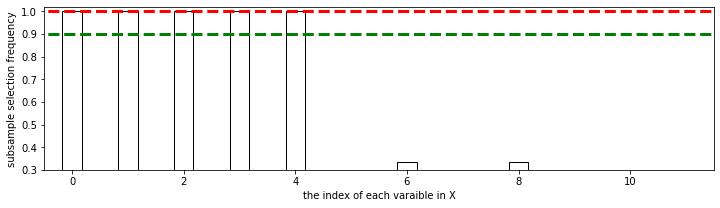

In [14]:
ind = np.arange(12)

fig, ax = plt.subplots(figsize=(12,3))

ax.bar(ind, qhat_value[0], 0.35, edgecolor="black", color="white")
ax.hlines(1, -1, 13, linewidth=3, color='red', linestyles='dashed')
ax.hlines(0.9, -1, 13, linewidth=3, color='green', linestyles='dashed')

ax.set_xlim([-0.5, 11.5])
ax.set_ylim([0.3, 1.02])

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlabel("the index of each varaible in X")
plt.ylabel("subsample selection frequency")

plt.show()

## check the active set of bsolar

In [15]:
print("the active set with f=1.0 :", Q_opt_c_H)

the active set with f=1.0 : [0, 1, 2, 3, 4]


In [16]:
print("the active set with f=0.9 :", Q_opt_c_S)

the active set with f=0.9 : [0, 1, 2, 3, 4]


## finaly, producing this into html

In [1]:
!rm -rf bsolar_walkthrough.html
!jupyter nbconvert --to html bsolar_walkthrough.ipynb 

[NbConvertApp] Converting notebook bsolar_walkthrough.ipynb to html
[NbConvertApp] Writing 675806 bytes to bsolar_walkthrough.html
